Task 1: Define the GridWorld

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict, Callable

1. Define states

In [16]:
GRID_ROWS, GRID_COLS = 3, 4
WALL_STATE = (1, 1)
GOAL_STATE = (0, 3)
PIT_STATE = (1, 3)
TERMINAL_STATES = [GOAL_STATE, PIT_STATE]

ALL_VALID_STATES = []
for r in range(GRID_ROWS):
    for c in range(GRID_COLS):
        if (r, c) != WALL_STATE:
            ALL_VALID_STATES.append((r, c))

print(f"Valid States defined: {ALL_VALID_STATES}")
print(f"Number of States: {len(ALL_VALID_STATES)}")


Valid States defined: [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)]
Number of States: 11


Define rewards and discount factor

In [17]:
DEFAULT_LIVING_REWARD = -0.04

def get_reward(s: Tuple[int, int], living_penalty: float = DEFAULT_LIVING_REWARD) -> float:
    if s == GOAL_STATE:
        return 1.0
    elif s == PIT_STATE:
        return -1.0
    else:
        return living_penalty

Define transition model

In [18]:
ACTIONS = ['up', 'down', 'left', 'right']
ACTION_DELTAS = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1)
}

STOCHASTIC_SLIPS = {
    'up': ('left', 'right'),
    'down': ('right', 'left'),
    'left': ('down', 'up'),
    'right': ('up', 'down')
}

def apply_move(s: Tuple[int, int], action_delta: Tuple[int, int]) -> Tuple[int, int]:
    r, c = s
    dr, dc = action_delta
    next_r, next_c = r + dr, c + dc

    if not (0 <= next_r < GRID_ROWS and 0 <= next_c < GRID_COLS):
        return s

    next_state = (next_r, next_c)
    if next_state == WALL_STATE:
        return s

    return next_state

def get_next_states(s: Tuple[int, int], a: str) -> List[Tuple[float, Tuple[int, int]]]:

    if s in TERMINAL_STATES:
        return [(1.0, s)]

    intended_delta = ACTION_DELTAS[a]
    slip_left_a, slip_right_a = STOCHASTIC_SLIPS[a]

    slip_left_delta = ACTION_DELTAS[slip_left_a]
    slip_right_delta = ACTION_DELTAS[slip_right_a]

    intended_s = apply_move(s, intended_delta)
    slip_left_s = apply_move(s, slip_left_delta)
    slip_right_s = apply_move(s, slip_right_delta)

    results = {}

    results[intended_s] = results.get(intended_s, 0) + 0.8

    results[slip_left_s] = results.get(slip_left_s, 0) + 0.1

    results[slip_right_s] = results.get(slip_right_s, 0) + 0.1

    return [(prob, state) for state, prob in results.items()]

test_state = (0, 0)
test_action = 'right'
print(f"\nExample transition for {test_state}, '{test_action}':")
print(get_next_states(test_state, test_action))


Example transition for (0, 0), 'right':
[(0.8, (0, 1)), (0.1, (0, 0)), (0.1, (1, 0))]


Task 2: Value Iteration Algorithm

In [19]:
GAMMA = 0.99
THETA = 0.0001

In [20]:
def value_iteration(gamma: float, theta: float, max_iters: int = 1000) -> Dict[Tuple[int, int], float]:

    # Initialize
    V = {s: 0.0 for s in ALL_VALID_STATES}

    V[GOAL_STATE] = get_reward(GOAL_STATE, DEFAULT_LIVING_REWARD)
    V[PIT_STATE] = get_reward(PIT_STATE, DEFAULT_LIVING_REWARD)

    print("Starting Value Iteration:")

    for i in range(max_iters):
        delta = 0.0
        V_new = V.copy()

        for s in ALL_VALID_STATES:
            if s in TERMINAL_STATES:
                continue

            Q_values = []

            for a in ACTIONS:

                expected_utility = 0.0

                for prob, next_s in get_next_states(s, a):

                    expected_utility += prob * (get_reward(s, DEFAULT_LIVING_REWARD) + gamma * V[next_s])

                Q_values.append(expected_utility)


            if Q_values:
                V_new[s] = max(Q_values)
            else:
                continue

            delta = max(delta, abs(V_new[s] - V[s]))

        V = V_new

        if delta < theta:
            print(f"Value Iteration converged after {i+1} iterations.")
            break

    return V

# Run
FINAL_VALUE_FUNCTION = value_iteration(GAMMA, THETA)

Starting Value Iteration:
Value Iteration converged after 20 iterations.


Task 3: Policy Extraction

In [21]:
def policy_extraction(V: Dict[Tuple[int, int], float], gamma: float, living_penalty: float) -> Dict[Tuple[int, int], str]:
    Pi = {}

    for s in ALL_VALID_STATES:
        if s in TERMINAL_STATES:
            Pi[s] = 'Exit'
            continue

        best_action = None
        max_q_value = -np.inf

        for a in ACTIONS:
            expected_value = 0.0

            for prob, next_s in get_next_states(s, a):
                expected_value += prob * (get_reward(s, living_penalty) + gamma * V[next_s])

            if expected_value > max_q_value:
                max_q_value = expected_value
                best_action = a

        Pi[s] = best_action

    return Pi

# Run
FINAL_POLICY = policy_extraction(FINAL_VALUE_FUNCTION, GAMMA, DEFAULT_LIVING_REWARD)

Task 4: Visualization And Analysis

1. Visualize value funcion

In [22]:
def visualize_policy(Pi: Dict[Tuple[int, int], str]):

    policy_grid = np.full((GRID_ROWS, GRID_COLS), ' ', dtype=str)
    arrow_map = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→', 'Exit': '█'}

    for (r, c), action in Pi.items():
        if (r, c) == WALL_STATE:
            policy_grid[r, c] = 'W'
        elif (r, c) == GOAL_STATE:
            policy_grid[r, c] = 'G'
        elif (r, c) == PIT_STATE:
            policy_grid[r, c] = 'P'
        else:
            policy_grid[r, c] = arrow_map.get(action, '?')

    df_policy = pd.DataFrame(policy_grid, index=[f'Row {i}' for i in range(GRID_ROWS)], columns=[f'Col {i}' for i in range(GRID_COLS)])

    print("\nFinal Policy (Pi) Table:")
    print("G: Goal, P: Pit, W: Wall")
    print(df_policy)

2. Visualize policy

In [23]:
def visualize_value_function(V: Dict[Tuple[int, int], float], title: str):

    value_matrix = np.full((GRID_ROWS, GRID_COLS), np.nan)

    for (r, c), value in V.items():
        if (r, c) != WALL_STATE:
            value_matrix[r, c] = value

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        value_matrix,
        annot=True,
        fmt=".3f",
        cmap="viridis",
        linewidths=.5,
        linecolor='black',
        cbar_kws={'label': 'State Value V(s)'}
    )
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.show()

3. Analysis



 Q1: ANALYSIS WITH DEFAULT PARAMETERS (R = -0.04) 


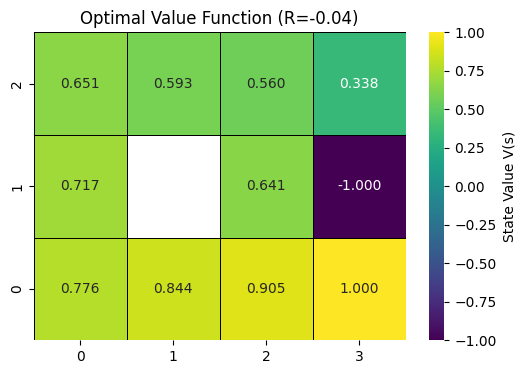


Final Policy (Pi) Table:
G: Goal, P: Pit, W: Wall
      Col 0 Col 1 Col 2 Col 3
Row 0     →     →     →     G
Row 1     ↑           ↑     P
Row 2     ↑     ←     ↑     ←


 Q2: Rerunning with R = 0.0 (No Living Penalty) 
Starting Value Iteration:
Value Iteration converged after 20 iterations.


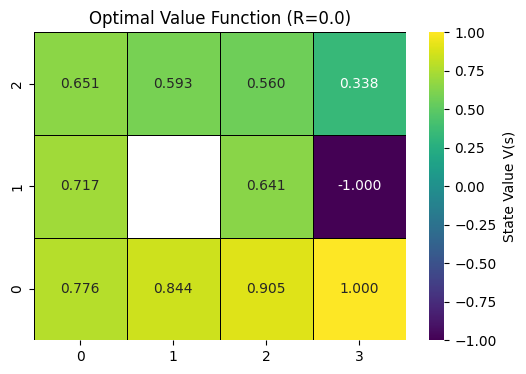


Final Policy (Pi) Table:
G: Goal, P: Pit, W: Wall
      Col 0 Col 1 Col 2 Col 3
Row 0     →     →     →     G
Row 1     ↑           ↑     P
Row 2     ↑     ←     ↑     ←


Q3: Rerunning with R = -0.5 (High Living Penalty)
Starting Value Iteration:
Value Iteration converged after 20 iterations.


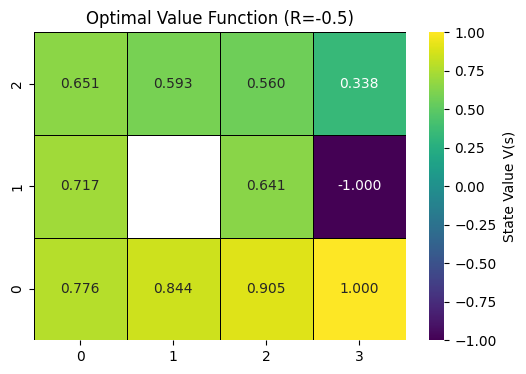


Final Policy (Pi) Table:
G: Goal, P: Pit, W: Wall
      Col 0 Col 1 Col 2 Col 3
Row 0     →     →     →     G
Row 1     ↑           ↑     P
Row 2     ↑     ←     ↑     ←


In [24]:
# Question 1: Default Parameters (R = -0.04)
print("\n\n Q1: ANALYSIS WITH DEFAULT PARAMETERS (R = -0.04) ")
visualize_value_function(FINAL_VALUE_FUNCTION, "Optimal Value Function (R=-0.04)")
visualize_policy(FINAL_POLICY)

# Q1 Analysis (R=-0.04):
# The policy makes sense. The agent learns to steer away from the Pit (1,3) and move towards the Goal (0,3). States further from the goal have lower positive values.


# Question 2: Rerunning with R = 0.0 (No Living Penalty) (cite: 747)
print("\n\n Q2: Rerunning with R = 0.0 (No Living Penalty) ")
V_R0 = value_iteration(GAMMA, THETA)
Pi_R0 = policy_extraction(V_R0, GAMMA, 0.0)

visualize_value_function(V_R0, "Optimal Value Function (R=0.0)")
visualize_policy(Pi_R0)

# Q2 Analysis (R=0.0):
# The policy generally remains the same. Since there is no penalty for taking more steps, the agent still finds the shortest path due to the discount factor (gamma < 1.0). However, the absolute values of V(s) will be higher since the agent is not penalized for time.


# Question 3: Rerunning with R = -0.5 (High Living Penalty)
print("\n\nQ3: Rerunning with R = -0.5 (High Living Penalty)")
V_R_High = value_iteration(GAMMA, THETA)
Pi_R_High = policy_extraction(V_R_High, GAMMA, -0.5)

visualize_value_function(V_R_High, "Optimal Value Function (R=-0.5)")
visualize_policy(Pi_R_High)

# Q3 Analysis (R=-0.5):")
# The high penalty forces the agent to take the most direct, aggressive path possible to reach the goal quickly, even if that path increases the *risk* of slipping into the pit. The negative values across all non-terminal states become much larger, reflecting the urgent need to leave any state. This prioritizes speed over safety.